#### <h1>Propaganda detection stepts:</h1> 

In [1]:
import os 
import pandas as pd
from os import listdir
from os.path import isfile, join
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import resample
import pickle
import sklearn
import re
from sklearn.externals import joblib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [2]:
os.chdir("D:\\Semeval2019")
train = ("D:\\Semeval2019\\datasets\\train-articles")
labels = ("D:\\Semeval2019\\datasets\\train-labels-SLC")

In [3]:
files_names = [f for f in listdir(train) if isfile(join(train, f))]
files_labels = [f for f in listdir(labels) if isfile(join(labels, f))]

<h2>The function for building the corpus</h2>

In [4]:
frames = []
def create_df():
    data = pd.DataFrame(columns = ["article","text","label"])
    for file,label in zip(files_names,files_labels):
        tup = (file,label)
        with open(train+'\\'+file,'r',encoding = 'utf-8') as file:
            file = file.readlines()
            label_data = pd.read_csv(labels+'\\'+label,sep = '\t',header = None)
            text_data = pd.DataFrame(columns = ["article","text","label"])
            text_data.text = file
            label_data.columns = ['articles', 'index','label']
            text_data.label,text_data.article  = label_data.label,label_data.articles
            text_data["text"] = text_data["text"].replace('\n',',')
            df = text_data[text_data.text != ',']
            frames.append(df)
            continue
    
    result = pd.concat(frames)
    return result.to_csv('result.tsv',sep = '\t')

<h2>Building the dataframe and droping useless information:

In [33]:
data = pd.read_csv('result.tsv',sep = '\t')
data = data.drop(columns = ['Unnamed: 0', 'article'])
data[:10]


,text,label
0,US bloggers banned from entering UK\n,non-propaganda
1,"Two prominent US bloggers have been banned from entering the UK, the Home Office has said.\n",non-propaganda
2,Pamela Geller and Robert Spencer co-founded anti-Muslim group Stop Islamization of America.\n,propaganda
3,"They were due to speak at an English Defence League march in Woolwich, where Drummer Lee Rigby was killed.\n",non-propaganda
4,"A government spokesman said individuals whose presence ""is not conducive to the public good"" could be excluded by the home secretary.\n",non-propaganda
5,"He added: ""We condemn all those whose behaviours and views run counter to our shared values and will not stand for extremism in any form.""\n",propaganda
6,'Right decision'\n,non-propaganda
7,"Ms Geller, of the Atlas Shrugs blog, and Mr Spencer, of Jihad Watch, are also co-founders of the American Freedom Defense Initiative, best known for a pro-Israel ""Defeat Jihad"" poster campaign on the New York subway.\n",propaganda
8,"On both of their blogs the pair called their bans from entering the UK ""a striking blow against freedom"" and said the ""the nation that gave the world the Magna Carta is dead"".\n",propaganda
9,"They were due to attend a march planned by the far-right EDL to mark Armed Forces Day on 29 June, ending in Woolwich, south east London, where soldier Drummer Rigby was murdered last month.\n",non-propaganda


In [36]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

In [37]:
data['totalwords'] = data['text'].str.split().str.len() #number of words

data['char_count'] = data['text'].str.len() #number of characters

data['avg_word'] = data['text'].apply(lambda x: avg_word(x)) # number of average word

data['numerics'] = data['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()])) # number of numeric digits

data['upper'] = data['text'].apply(lambda x: len([x for x in x.split() if x.isupper()])) # number of uppercase

data['sentiment'] = data['text'].apply(lambda x: TextBlob(x).sentiment[0]) # sentiment analysis
data.head()
data.index

RangeIndex(start=0, stop=16297, step=1)

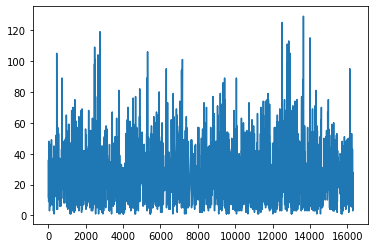

In [123]:
prop_df = data[data.label == "propaganda"]
non_prop_df = data[data.label == "non-propaganda"]

plt.plot(prop_df.totalwords)
non_prop_df = data[data.label == "non-propaganda"]








In [136]:
all_data = data
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
def clean_stop_words(text):
    word_tokens = tokenizer.tokenize(text.lower())
    return [w for w in word_tokens if not w in stop_words]
pd.set_option('display.max_colwidth',-1)
propaganda_sentences = all_data.loc[all_data['label'] == 'propaganda']['text'].values
non_propaganda_sentences = all_data.loc[all_data['label'] == 'non-propaganda']['text'].values
hist1_data = [len(clean_stop_words(sent)) for sent in propaganda_sentences]
hist2_data = [len(clean_stop_words(sent)) for sent in non_propaganda_sentences]

trace1 = go.Histogram(
    y=non_prop_df.totalwords,
    opacity=0.75,
    name = 'propaganda'
)
trace2 = go.Histogram(
    y=prop_df.totalwords,
    opacity=0.75,
    name='non-propaganda'
)

data_plot = [trace1, trace2]
layout = go.Layout()
fig = go.Figure(data=data_plot, layout=layout)

iplot(fig, filename='word per propaganda and non-propaganda sentence')

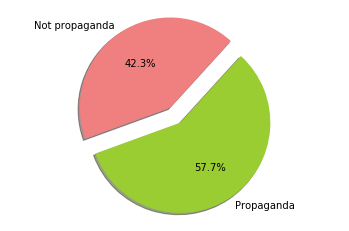

In [9]:
a = all_data.loc[all_data['label'] == 'propaganda'].char_count.mean()
b = all_data.loc[all_data['label'] == 'non-propaganda'].char_count.mean()

labels = 'Propaganda', 'Not propaganda'
sizes = [a, b]
colors = ['yellowgreen','lightcoral']
explode = (0.1,0.1)
plt.pie(sizes, explode = (0.1,0.1),labels=labels, colors=colors,autopct= '%1.1f%%', shadow=True, startangle=200)
plt.axis('equal')
plt.show()

In [138]:
import numpy as np
from itertools import groupby
def most_common_words_by_label(label):
    sentences = all_data.loc[all_data['label'] == label]['text'].values
    all_words = np.concatenate([clean_stop_words(text) for text in sentences])
    all_words.sort()
    words_by_len = [(key, len(list(group))/len(sentences)) for key, group in groupby(all_words)]
    words_by_len.sort(key=lambda x: -x[1])
    return words_by_len[:20]

top_propaganda_words = most_common_words_by_label('propaganda')
top_non_propaganda_words = most_common_words_by_label('non-propaganda')

trace1 = go.Bar(
    x=[word[0] for word in top_non_propaganda_words],
    y=[word[1] for word in top_non_propaganda_words],
    name='non-propaganda'
)
trace2 = go.Bar(
    x=[word[0] for word in top_propaganda_words],
    y=[word[1] for word in top_propaganda_words],
    name='propaganda'
)

# iplot(data, filename='most common words in propaganda sentences')
data_plot = [trace1, trace2]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data_plot, layout=layout)
iplot(fig, filename='most-common-words')

<h4> A word-cloud diagram containg the most frequent words in the training data labeled as 'propaganda'


In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="black").generate(str(prop["text"]))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


<h4>A word-cloud diagram containg the most frequent words in the training data labeled as 'non-propaganda'

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="black").generate(str(non_prop["text"]))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<h2>Data cleaning: removing stop-words, symbols, whitespaces

In [ ]:
replaceBySpaceRe = re.compile('[/(){}\[\]\|@,;#]')
badSymbolsRe = re.compile('[^0-9a-z #+_]')
stopWords = set(stopwords.words('english'))
def clean_text(post):
    post = post.lower()
    post = replaceBySpaceRe.sub(' ', post) 
    post = badSymbolsRe.sub('', post) 
    post = ' '.join(word for word in post.split() if word not in stopWords)
    return post
    
data['text'] = data['text'].apply(clean_text)
data['text'][:10]



<h1>Data analysis:</h1>


In [165]:
data['label'].value_counts()

non-propaganda    11577
propaganda        4720 
Name: label, dtype: int64



<h5>Ploting the data, we can notice that classes are unbalanced: 




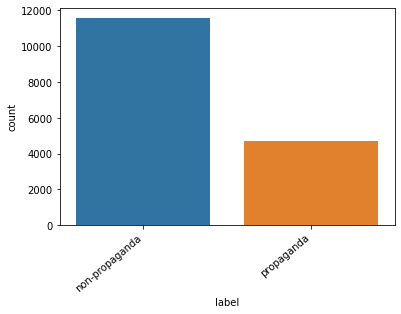

<Figure size 7200x7200 with 0 Axes>

In [166]:
ax = sns.countplot(data.label)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.figure(figsize=(100,100))
plt.show()


<h5>Splitting and balancing the data by upsampling the minority class: 

In [73]:
X = data.text
y = data.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [74]:
X = pd.concat([X_train, y_train], axis=1)
# separate minority and majority classes
nonPropaganda = X[X.label=='non-propaganda']
propaganda = X[X.label=='propaganda']

# upsample minority
propagandaUpSampled = resample(propaganda,
                          replace=True, # sample with replacement
                          n_samples=len(nonPropaganda), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
df = pd.concat([nonPropaganda, propagandaUpSampled])

# check new class counts
df.label.value_counts()

propaganda        8085
non-propaganda    8085
Name: label, dtype: int64

<h5> Balanced data:

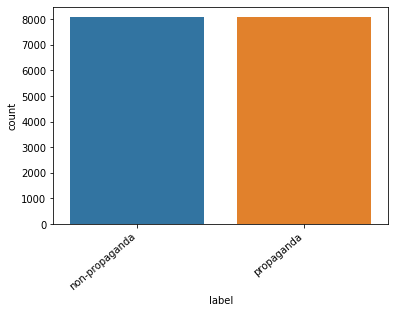

<Figure size 7200x7200 with 0 Axes>

In [75]:
ax = sns.countplot(df.label)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.figure(figsize=(100,100))
plt.show()

<h3>Splitting the data into training and testing (80:20): 

In [10]:
X = df.text
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

NameError: name 'df' is not defined

<h2>Multinomial Naive Bayes 

In [ ]:
from sklearn.naive_bayes import MultinomialNB


nb = Pipeline([('vect', CountVectorizer(ngram_range=(1,6), analyzer='char')),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)
print("Multinomial Naive Bayes \n")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

<h2> Logistic Regression 

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 6), analyzer='char')),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)



y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

<h2>Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = Pipeline([('vect', CountVectorizer(ngram_range=(1,6), analyzer='char')),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier ()),
               ])
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
print("Random Forest Classifier \n")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

<h2> Support Vector Machine

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1, 6), analyzer='char')),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)



y_pred = sgd.predict(X_test)
print ("Support Vector Machine \n")
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

<h1> Task 2. Propaganda Classification 

<h3> Loading the data 

In [14]:
os.chdir('D:\\MLC\\Sem3\\Pragmatica LN\\datasets\\train-articles')
df = pd.read_csv('D:\\MLC\\Sem3\\Pragmatica LN\\datasets\\train2.csv')
Row_list=[]
for index, rows in df.iterrows(): 
    my_list =['article'+str(rows.Article)+'.txt',rows.start, rows.end, rows.Lable]
    Row_list.append(my_list)

In [15]:
Final_list=[]
Plain_text  = []
def span1(First_List):
        for files in First_List:
            filename = files[0]
            with open(filename,'r', encoding='utf-8') as fd:
                span = fd.read()
                x = span[files[1]:files[2]]
                Plain_text.append(x)
                Final_list.append([filename, str(x), files[3]])   
        
                continue

In [16]:
span1(Row_list)

In [17]:
spanframe = pd.DataFrame(Final_list, columns=['article','text', 'lable'])
filter = spanframe["text"] != ""
Corpus = spanframe[filter]


In [18]:
Corpus['lable'].value_counts()

Loaded_Language                       2199
Name_Calling,Labeling                 1105
Repetition                            621 
Doubt                                 496 
Exaggeration,Minimisation             493 
Appeal_to_fear-prejudice              321 
Flag-Waving                           250 
Causal_Oversimplification             212 
Appeal_to_Authority                   155 
Slogans                               138 
Black-and-White_Fallacy               112 
Whataboutism,Straw_Men,Red_Herring    109 
Thought-terminating_Cliches           80  
Bandwagon,Reductio_ad_hitlerum        77  
Name: lable, dtype: int64

<h3> Data Visualiation

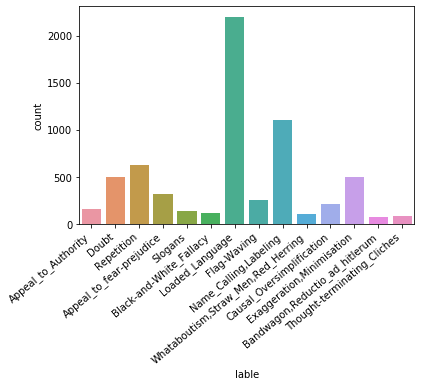

<Figure size 7200x7200 with 0 Axes>

In [19]:
ax = sns.countplot(Corpus.lable)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.figure(figsize=(100,100))
plt.show()

<h3> Data cleaning

In [20]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(post):
    post = post.lower()
    post = REPLACE_BY_SPACE_RE.sub(' ', post) 
    post = BAD_SYMBOLS_RE.sub('', post) 
    post = ' '.join(word for word in post.split() if word not in STOPWORDS)
    return post
    
Corpus['text'] = Corpus['text'].apply(clean_text)

<h3>Splitting the data into training and testing (80:20):

In [21]:
X = Corpus.text
y = Corpus.lable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

<h2>Multinomial Naive Bayes 

In [22]:
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('vect', CountVectorizer(ngram_range=(1,6), analyzer='char')),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))


accuracy 0.43328100470957615
                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.00      0.00      0.00        28
          Appeal_to_fear-prejudice       0.00      0.00      0.00        55
    Bandwagon,Reductio_ad_hitlerum       0.00      0.00      0.00        15
           Black-and-White_Fallacy       0.00      0.00      0.00        24
         Causal_Oversimplification       0.00      0.00      0.00        35
                             Doubt       0.00      0.00      0.00        92
         Exaggeration,Minimisation       0.00      0.00      0.00        93
                       Flag-Waving       0.71      0.12      0.20        43
                   Loaded_Language       0.41      0.98      0.58       493
             Name_Calling,Labeling       0.72      0.19      0.30       217
                        Repetition       0.91      0.18      0.30       118
                           Slogans       0.00      0.00   

<h2> Support Vector Machine

In [23]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1, 6), analyzer='char')),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)



y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.532967032967033
                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.23      0.11      0.15        28
          Appeal_to_fear-prejudice       0.30      0.24      0.27        55
    Bandwagon,Reductio_ad_hitlerum       0.46      0.40      0.43        15
           Black-and-White_Fallacy       0.08      0.04      0.05        24
         Causal_Oversimplification       0.30      0.20      0.24        35
                             Doubt       0.42      0.49      0.45        92
         Exaggeration,Minimisation       0.40      0.13      0.20        93
                       Flag-Waving       0.35      0.49      0.41        43
                   Loaded_Language       0.59      0.86      0.70       493
             Name_Calling,Labeling       0.54      0.43      0.48       217
                        Repetition       0.66      0.36      0.47       118
                           Slogans       0.50      0.37     

<h2> Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 6), analyzer='char')),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)



y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5094191522762951
                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.30      0.29      0.29        28
          Appeal_to_fear-prejudice       0.22      0.20      0.21        55
    Bandwagon,Reductio_ad_hitlerum       0.31      0.33      0.32        15
           Black-and-White_Fallacy       0.10      0.04      0.06        24
         Causal_Oversimplification       0.18      0.23      0.20        35
                             Doubt       0.39      0.55      0.46        92
         Exaggeration,Minimisation       0.32      0.32      0.32        93
                       Flag-Waving       0.29      0.47      0.36        43
                   Loaded_Language       0.66      0.68      0.67       493
             Name_Calling,Labeling       0.59      0.47      0.52       217
                        Repetition       0.57      0.58      0.58       118
                           Slogans       0.44      0.42    

<h2> Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier
rfc = Pipeline([('vect', CountVectorizer(ngram_range=(1,6), analyzer='char')),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier()),
               ])
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))


accuracy 0.5266875981161695
                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.00      0.00      0.00        28
          Appeal_to_fear-prejudice       0.13      0.04      0.06        55
    Bandwagon,Reductio_ad_hitlerum       0.38      0.20      0.26        15
           Black-and-White_Fallacy       0.17      0.04      0.07        24
         Causal_Oversimplification       0.67      0.06      0.11        35
                             Doubt       0.36      0.52      0.43        92
         Exaggeration,Minimisation       0.41      0.17      0.24        93
                       Flag-Waving       0.53      0.44      0.48        43
                   Loaded_Language       0.55      0.88      0.68       493
             Name_Calling,Labeling       0.59      0.34      0.43       217
                        Repetition       0.68      0.53      0.59       118
                           Slogans       0.40      0.32    